# NLP Project
### Goal: Create a model that best predicts programming languages of Github repositories 

### Plan 

Scrape Github repositories to exaluate the README sections and build a model that will predict which programming language is used. 
- 100 repositories used 
- 8 different models

### **Data Dictionary**

   - **Language:** Programming language used for repositort project

   - **README Content:** Description of each repository containing keywords used to make predictions

   - **Normalized:** README content normalized removing any uppercased characters, special characters, non-alpha characters, and alpha strings with 2 or less characters

   - **Stemmed:** README content reducing each word to its root stem 

   - **Lemmatized:** README content reducing each word to its root word

   - **Cleaned:** README content that has been lemmatized and then removes any stopwords 

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from requests import get
from bs4 import BeautifulSoup
import os
import json
import re
import unicodedata

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)
from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

import acquire
import prepare
from env import github_token

### Acquire

Using our acquire.py file, we scraped URL's from Github to create a Corpus of data

In [2]:
#acquire.scrape_github_data()

In [3]:
original_df = pd.read_json('data.json')

In [4]:
original_df.head()

,language,readme_contents,repo
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,AIDungeon/AIDungeon
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",rclone/rclone
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,marblexu/PythonPlantsVsZombies
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...",redox-os/orbtk
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,sailay1996/UAC_Bypass_In_The_Wild


In [5]:
original_df.shape

(107, 3)

In [6]:
# We can see that there are 7 null values in the language column.
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 3 columns):
language           100 non-null object
readme_contents    107 non-null object
repo               107 non-null object
dtypes: object(3)
memory usage: 2.6+ KB


In [7]:
# We have pulled in 18 different language
original_df.language.value_counts()

JavaScript          25
Python              20
CSS                  9
Ruby                 9
Go                   7
HTML                 5
Java                 5
C++                  4
TypeScript           4
C                    2
PHP                  2
Jupyter Notebook     2
CoffeeScript         1
Haskell              1
Clojure              1
C#                   1
Kotlin               1
Rust                 1
Name: language, dtype: int64

In [8]:
# Drop any columns that do not have a language
original_df = original_df.dropna()

In [9]:
original_df.shape

(100, 3)

In [10]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 106
Data columns (total 3 columns):
language           100 non-null object
readme_contents    100 non-null object
repo               100 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


### Prepare

Make a copy of the original data frame we brought in dropping the repo column.

In [11]:
df = original_df[['language', 'readme_contents']]

In [12]:
df.head()

,language,readme_contents
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh..."
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl..."
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...


In [13]:
df = prepare.prep_contents(df)

Using a function from our prepare.py file, we created a new df displaying new columns using different methods to clean up the data.

In [14]:
df.head()

,language,readme_contents,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...","[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...","<img alt=""OrbTk"" width=""380"" src=""https://gitl...",img alt orbtk width src https gitla...,img alt orbtk width src http gitlab redox org ...,img alt orbtk width src http gitlab redox org ...,img alt width src gitlab redox org redox asset...
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,uac bypass the wild windows uac bypass for...,uac bypass the wild window uac bypass for all ...,uac bypass the wild window uac bypass for all ...,uac bypass wild window uac bypass executable f...


In [15]:
# Since we created a new column titled 'original', we will drop readme_contents column
df = df.drop(columns='readme_contents')

In [16]:
df.head(2)

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...


In [17]:
# Look at the contents using the cleaned column to assure it is cleaned up as we want it to be
df.cleaned[0]

'aidungeon model dungeon temporarily unavailable download due cost working solution read aidungeon wa built pcc byu edu dungeon creating infinitely generated text adventure deep learning language model play game colab aidungeon play game locally recommended nvidia gpu memory cuda installed gpu turn take couple minute game compose response install play locally git clone aidungeon aidungeon aidungeon install python play community aidungeon open source project question discussion contribution welcome contribution anything new package bugfixes documentation even new core feature resource website aidungeon aidungeon aidungeon twitter creator nickwalton twitter nickwalton dev benjbay twitter benjbay reddit aidungeon reddit aidungeon discord aidungeon discord discord vcz contributing contributing aidungeon relatively easy send pull request help article using pull request fork send request make develop destination branch aidungeon repository nickwalton aidungeon prefer pr pep python org dev pe

**Takeaway:** Moving forward, we will use the 'cleanded' column to explore and model. We chose to move forward with the lemmatized and removed stopwords column due to the fact that lemmatize is more accurate than stemming, working with a dictionary rather than guessing the word.


### Explore

In [18]:
df.language.value_counts()

JavaScript          25
Python              20
CSS                  9
Ruby                 9
Go                   7
HTML                 5
Java                 5
C++                  4
TypeScript           4
C                    2
PHP                  2
Jupyter Notebook     2
CoffeeScript         1
Haskell              1
Clojure              1
C#                   1
Kotlin               1
Rust                 1
Name: language, dtype: int64

In [19]:
df.language.count()

100

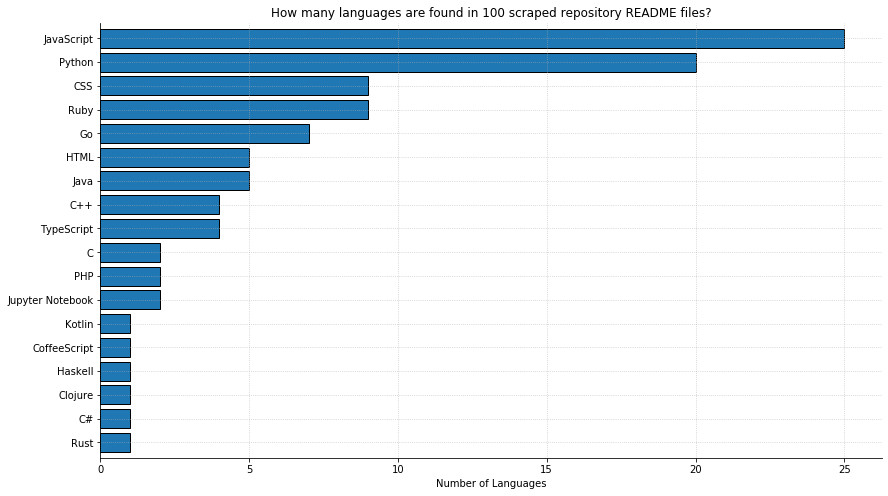

In [20]:
plt.figure(figsize=(14,8))
df.language.value_counts().sort_values(ascending=True).plot.barh(width=.8)
plt.title('How many languages are found in 100 scraped repository README files?')
plt.xlabel('Number of Languages')
plt.show()

In [21]:
# We created a new df to display the number of times a language appears abd the percentages that each programming language is featured in our corpus
percents = pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)
percents

,n,percent
JavaScript,25,0.25
Python,20,0.20
CSS,9,0.09
Ruby,9,0.09
Go,7,0.07
HTML,5,0.05
Java,5,0.05
C++,4,0.04
TypeScript,4,0.04
C,2,0.02


In [22]:
# Moving forward with the cleaned column from our df, we will create a new series splitting the words, then look at counts
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()
raw_count

org                        634
img                        558
file                       514
src                        489
svg                        470
html                       394
code                       384
use                        364
doc                        354
href                       324
master                     316
project                    315
license                    301
cs                         292
plugin                     275
badge                      274
build                      269
using                      254
run                        249
line                       230
install                    230
png                        217
image                      211
python                     208
release                    205
version                    204
opencollective             197
example                    197
new                        196
test                       196
                          ... 
invalida                     1
reserved

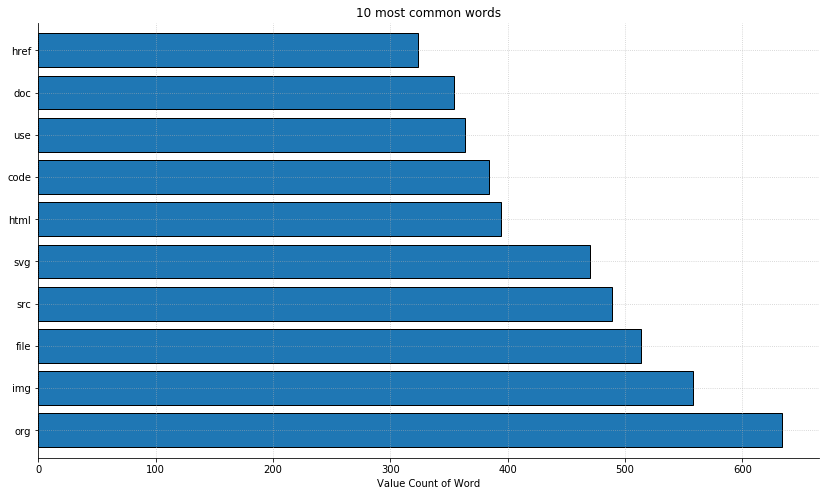

In [23]:
plt.figure(figsize=(14,8))
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.title('10 most common words')
plt.xlabel('Value Count of Word')
plt.show()

Create a new df to look at the count, the frequency and the augmented frequency to see next to each other to see the differences.

In [24]:
tf_df = (pd.DataFrame({'raw_count': raw_count})
         .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
         .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

tf_df.head()

,raw_count,frequency,augmented_frequency
org,634,0.008636,1.000000
img,558,0.007600,0.880126
file,514,0.007001,0.810726
src,489,0.006661,0.771293
svg,470,0.006402,0.741325


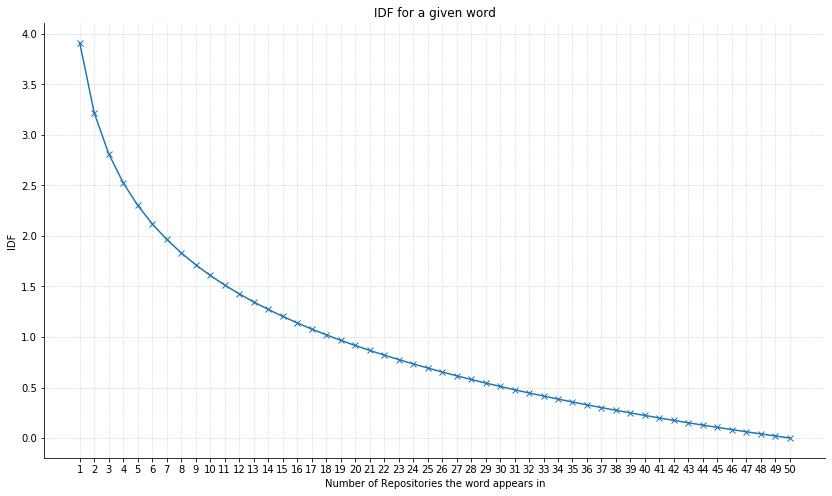

In [25]:
n_documents = 50

x_denominator = np.arange(1, n_documents + 1)
y_idf = np.log(n_documents / x_denominator)

plt.figure(figsize=(14, 8))
plt.plot(x_denominator, y_idf, marker='x')

plt.xticks(x_denominator)
plt.xlabel('Number of Repositories the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')
plt.show()

In [26]:
# We will use this function to calculate the IDF of each word
def idf(word):
    n_occurrences = sum([1 for doc in df.cleaned if word in doc])
    n_docs = len(df.cleaned)
    idf = np.log(n_docs/n_occurrences)
    return idf

In [27]:
# Find the unique words in the entire df to calculate the IDF
unique_words = pd.Series(' '.join(df.cleaned).split()).unique()

In [28]:
unique_words

array(['aidungeon', 'model', 'dungeon', ..., 'healthy', 'downstream',
       'schema'], dtype=object)

In [29]:
idf_df = pd.DataFrame(dict(word = unique_words))\
    .assign(idf = lambda df: df.word.apply(idf))\
    .set_index('word').sort_values(by='idf', ascending = False)

idf_df.head(10)

,idf
word,
aidungeon,4.60517
prerelease,4.60517
rollout,4.60517
zoomin,4.60517
diligently,4.60517
relating,4.60517
zoomindown,4.60517
zoominleft,4.60517
externally,4.60517


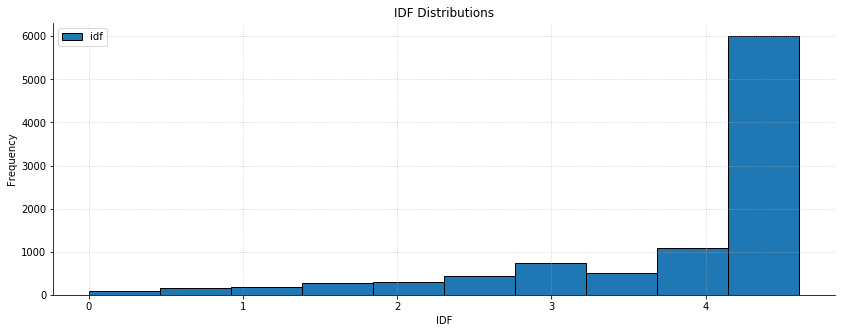

In [30]:
idf_df.plot.hist(figsize=(14,5))
plt.title('IDF Distributions')
plt.xlabel('IDF')
plt.show()

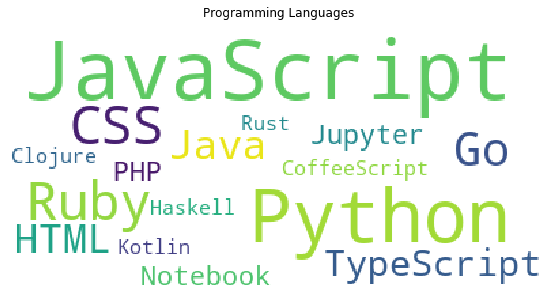

In [31]:
# Look at the programming language value counts and create a word cloud of the words
all_cloud = WordCloud(background_color='white').generate(' '.join(df.language))
plt.figure(figsize=(12, 5))
plt.imshow(all_cloud)
plt.title('Programming Languages')
plt.axis('off')
plt.show()

In [32]:
# Now we will create a word cloud of all words in the data and visualize the most prominent
all_text = " ".join(df.cleaned)

In [33]:
all_words = prepare.clean(all_text)
all_words

['aidungeon',
 'model',
 'dungeon',
 'temporarily',
 'unavailable',
 'download',
 'due',
 'cost',
 'working',
 'solution',
 'read',
 'aidungeon',
 'wa',
 'built',
 'pcc',
 'byu',
 'edu',
 'dungeon',
 'creating',
 'infinitely',
 'generated',
 'text',
 'adventure',
 'deep',
 'learning',
 'language',
 'model',
 'play',
 'game',
 'colab',
 'aidungeon',
 'play',
 'game',
 'locally',
 'recommended',
 'nvidia',
 'gpu',
 'memory',
 'cuda',
 'installed',
 'gpu',
 'turn',
 'take',
 'couple',
 'minute',
 'game',
 'compose',
 'response',
 'install',
 'play',
 'locally',
 'git',
 'clone',
 'aidungeon',
 'aidungeon',
 'aidungeon',
 'install',
 'python',
 'play',
 'community',
 'aidungeon',
 'open',
 'source',
 'project',
 'question',
 'discussion',
 'contribution',
 'welcome',
 'contribution',
 'anything',
 'new',
 'package',
 'bugfixes',
 'documentation',
 'even',
 'new',
 'core',
 'feature',
 'resource',
 'website',
 'aidungeon',
 'aidungeon',
 'aidungeon',
 'twitter',
 'creator',
 'nickwalton',
 

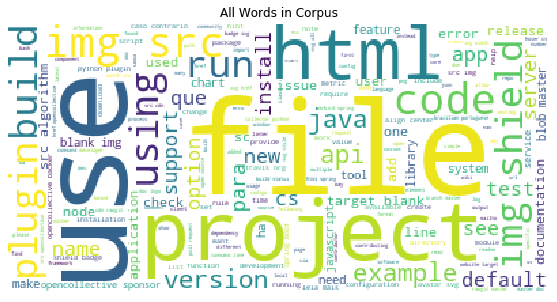

In [34]:
# Word cloud looking at all words in our corpus
img = WordCloud(background_color="white").generate(all_text)
plt.figure(figsize=(12, 5))
plt.imshow(img)
plt.axis("off")
plt.title('All Words in Corpus')
plt.show()

In [35]:
list(nltk.bigrams(all_text.split()))

[('aidungeon', 'model'),
 ('model', 'dungeon'),
 ('dungeon', 'temporarily'),
 ('temporarily', 'unavailable'),
 ('unavailable', 'download'),
 ('download', 'due'),
 ('due', 'cost'),
 ('cost', 'working'),
 ('working', 'solution'),
 ('solution', 'read'),
 ('read', 'aidungeon'),
 ('aidungeon', 'wa'),
 ('wa', 'built'),
 ('built', 'pcc'),
 ('pcc', 'byu'),
 ('byu', 'edu'),
 ('edu', 'dungeon'),
 ('dungeon', 'creating'),
 ('creating', 'infinitely'),
 ('infinitely', 'generated'),
 ('generated', 'text'),
 ('text', 'adventure'),
 ('adventure', 'deep'),
 ('deep', 'learning'),
 ('learning', 'language'),
 ('language', 'model'),
 ('model', 'play'),
 ('play', 'game'),
 ('game', 'colab'),
 ('colab', 'aidungeon'),
 ('aidungeon', 'play'),
 ('play', 'game'),
 ('game', 'locally'),
 ('locally', 'recommended'),
 ('recommended', 'nvidia'),
 ('nvidia', 'gpu'),
 ('gpu', 'memory'),
 ('memory', 'cuda'),
 ('cuda', 'installed'),
 ('installed', 'gpu'),
 ('gpu', 'turn'),
 ('turn', 'take'),
 ('take', 'couple'),
 ('coupl

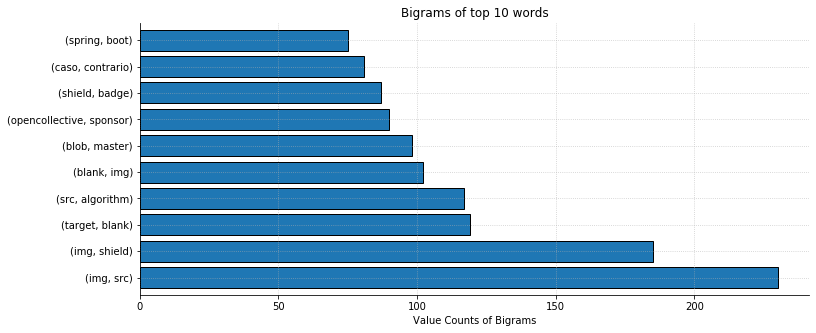

In [36]:
plt.figure(figsize=(12,5))
pd.Series(nltk.bigrams(all_words)).value_counts().head(10).plot.barh(width=.8)
plt.title('Bigrams of top 10 words')
plt.xlabel('Value Counts of Bigrams')
plt.show()

In [37]:
list(nltk.ngrams(all_text.split(), 3))

[('aidungeon', 'model', 'dungeon'),
 ('model', 'dungeon', 'temporarily'),
 ('dungeon', 'temporarily', 'unavailable'),
 ('temporarily', 'unavailable', 'download'),
 ('unavailable', 'download', 'due'),
 ('download', 'due', 'cost'),
 ('due', 'cost', 'working'),
 ('cost', 'working', 'solution'),
 ('working', 'solution', 'read'),
 ('solution', 'read', 'aidungeon'),
 ('read', 'aidungeon', 'wa'),
 ('aidungeon', 'wa', 'built'),
 ('wa', 'built', 'pcc'),
 ('built', 'pcc', 'byu'),
 ('pcc', 'byu', 'edu'),
 ('byu', 'edu', 'dungeon'),
 ('edu', 'dungeon', 'creating'),
 ('dungeon', 'creating', 'infinitely'),
 ('creating', 'infinitely', 'generated'),
 ('infinitely', 'generated', 'text'),
 ('generated', 'text', 'adventure'),
 ('text', 'adventure', 'deep'),
 ('adventure', 'deep', 'learning'),
 ('deep', 'learning', 'language'),
 ('learning', 'language', 'model'),
 ('language', 'model', 'play'),
 ('model', 'play', 'game'),
 ('play', 'game', 'colab'),
 ('game', 'colab', 'aidungeon'),
 ('colab', 'aidungeon',

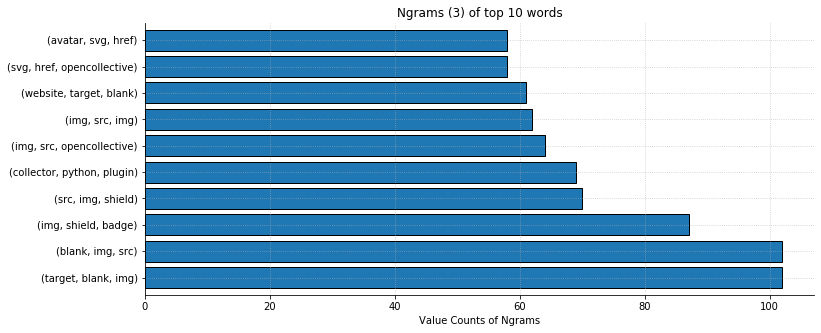

In [38]:
plt.figure(figsize=(12,5))
pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(10).plot.barh(width=.8)
plt.title('Ngrams (3) of top 10 words')
plt.xlabel('Value Counts of Ngrams')
plt.show()

In [39]:
# Look at the value counts of the top 25 bigrams
top_25_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(25))

top_25_bigrams

(img, src)                   230
(img, shield)                185
(target, blank)              119
(src, algorithm)             117
(blank, img)                 102
(blob, master)                98
(opencollective, sponsor)     90
(shield, badge)               87
(caso, contrario)             81
(spring, boot)                75
(align, center)               74
(leia, mais)                  72
(travis, org)                 72
(src, img)                    71
(avatar, svg)                 71
(opencollective, backer)      71
(python, plugin)              71
(collector, python)           69
(command, line)               67
(brazilian, portuguese)       66
(html, spring)                65
(src, opencollective)         64
(master, doc)                 64
(href, opencollective)        62
(build, status)               62
dtype: int64

Now we will look at the length of each individual README file and add a new column to display the word count.

In [40]:
df["readme_length"] = df.cleaned.apply(len)

In [41]:
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...,1206
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...,3289
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...,705
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...",img alt orbtk width src https gitla...,img alt orbtk width src http gitlab redox org ...,img alt orbtk width src http gitlab redox org ...,img alt width src gitlab redox org redox asset...,3541
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,uac bypass the wild windows uac bypass for...,uac bypass the wild window uac bypass for all ...,uac bypass the wild window uac bypass for all ...,uac bypass wild window uac bypass executable f...,339


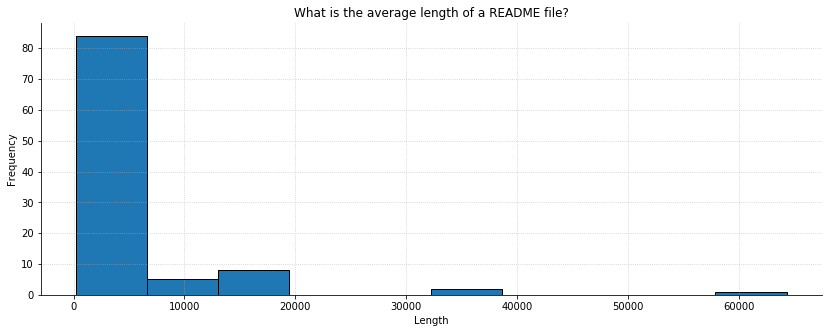

In [42]:
plt.figure(figsize=(14,5))
df.readme_length.plot.hist()
plt.title('What is the average length of a README file?')
plt.xlabel('Length')
plt.show()

**Takeaway:** A majority of word lengths are are between 1 - 500, with a few outliers in length.

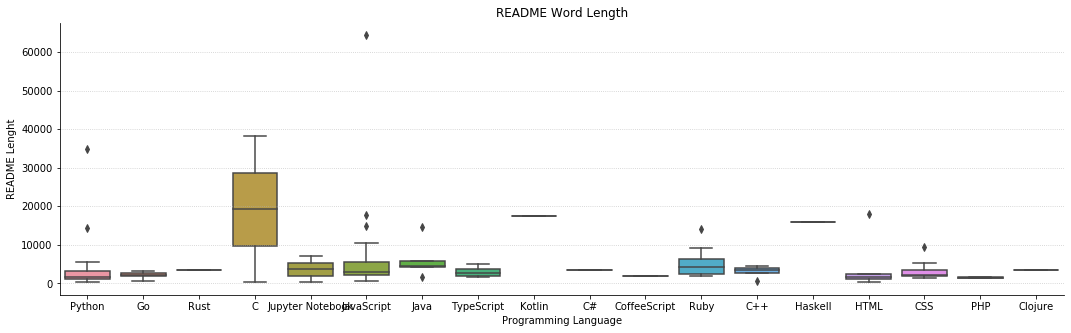

In [43]:
plt.figure(figsize=(18,5))
sns.boxplot(data=df, y="readme_length", x='language')
plt.title("README Word Length")
plt.xlabel('Programming Language')
plt.ylabel('README Lenght')
plt.show()

**Takeaway:** We can see with each language the average lenght and the few outliers in the individual language data.

*Do different programming languages use a different number of unique words?*

In [44]:
java = df[df.language == 'JavaScript'].sort_values(by='readme_length', ascending=True)
java.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
83,JavaScript,# Cumulus\nA SoundCloud player that lives in y...,cumulus soundcloud player that lives your me...,cumulu soundcloud player that live your menuba...,cumulus soundcloud player that life your menub...,cumulus soundcloud player life menubar release...,619
56,JavaScript,## [What Is Code?](http://www.bloomberg.com/wh...,what code http www bloomberg com whatisco...,what code http www bloomberg com whatiscod bus...,what code http www bloomberg com whatiscode bu...,code bloomberg businessweek june paul ford twi...,892
96,JavaScript,# Graphite-Web\n\n[![Codacy Badge](https://api...,graphite web codacy badge https api cod...,graphit web codaci badg http api codaci com pr...,graphite web codacy badge http api codacy com ...,graphite web codacy badge api codacy project b...,1174
29,JavaScript,# CSScomb [![CSSComb](logo.png)](http://csscom...,csscomb csscomb logo png http csscomb ...,csscomb csscomb logo png http csscomb com buil...,csscomb csscomb logo png http csscomb com buil...,logo png build status travis org svg branch ma...,1787
49,JavaScript,"# Meme v.2\n\nContributors: Yuri Victor, Joshu...",meme contributors yuri victor joshua ben...,meme contributor yuri victor joshua benton mat...,meme contributor yuri victor joshua benton mat...,contributor yuri victor joshua benton matt mon...,1979


In [45]:
java_words = pd.Series(" ".join(java.cleaned).split()).value_counts()
java_words.head(15)

src          309
img          257
que          189
para         169
org          169
doc          153
svg          139
mais         128
algorithm    125
png          124
href         123
master       119
npm          111
use          104
uma          103
dtype: int64

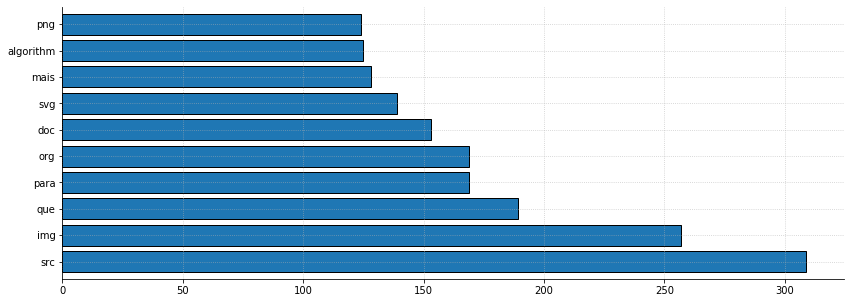

In [46]:
plt.figure(figsize=(14,5))
java_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

In [47]:
unique_java = pd.Series(' '.join(java.cleaned).split()).unique()
unique_java

array(['cumulus', 'soundcloud', 'player', ..., 'refack', 'refael',
       'ackermann'], dtype=object)

In [48]:
python = df[df.language == 'Python'].sort_values(by='readme_length', ascending=True)
python.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
43,Python,[![Build Status](https://dev.azure.com/asottil...,build status https dev azure com asottile a...,build statu http dev azur com asottil asottil ...,build status http dev azure com asottile asott...,build status dev azure asottile asottile apis ...,426
92,Python,OpenStack Tracking Repo\n=====================...,openstack tracking repo ...,openstack track repo zuul gate all the contain...,openstack tracking repo zuul gate all the cont...,tracking repo zuul gate contained project effe...,456
98,Python,Welcome to Fabric!\n==================\n\nFabr...,welcome fabric fabric ...,welcom fabric fabric high level python librari...,welcome fabric fabric high level python librar...,welcome high level python library designed exe...,465
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...,705
102,Python,".. raw:: html\n\n <p align=""center"">\n <...",raw html align center align ...,raw html align center align center href http s...,raw html align center align center href http s...,raw html align center align center href utm so...,883


In [49]:
python_words = pd.Series(" ".join(python.cleaned).split()).value_counts()
python_words.head(15)

file           161
bee            152
line           137
code           108
python         107
org             86
content         70
use             69
img             68
mean            68
style           66
mailto          62
pre             61
fixed           60
hellogithub     59
dtype: int64

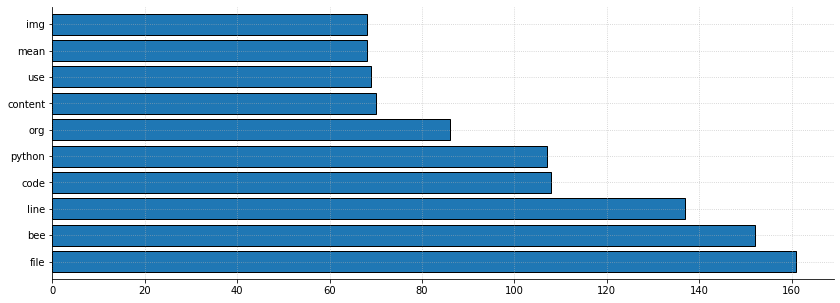

In [50]:
plt.figure(figsize=(14,5))
python_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

In [51]:
css = df[df.language == 'CSS'].sort_values(by='readme_length', ascending=True)
css.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
61,CSS,960 Grid System\n===============\n\nCreated by...,grid system created nathan s...,grid system creat nathan smith see the offici ...,grid system created nathan smith see the offic...,grid system created nathan smith see official ...,1349
71,CSS,# Basscss\n\nLow-level CSS toolkit – the origi...,basscss low level css toolkit the original ...,basscss low level css toolkit the origin funct...,basscss low level cs toolkit the original func...,low level cs toolkit original functional cs fu...,1882
70,CSS,# [Photon](http://photonkit.com/)\n\n[![Build ...,photon http photonkit com build statu...,photon http photonkit com build statu http img...,photon http photonkit com build status http im...,photonkit build status img shield travis maste...,1941
64,CSS,\n# [Flat UI Free](https://designmodo.github.i...,flat free https designmodo github flat ...,flat free http designmodo github flat flat bea...,flat free http designmodo github flat flat bea...,flat free flat flat beautiful theme getbootstr...,2201
62,CSS,"# normalize.css\n\n<a href=""https://github.com...",normalize css href https github com neco...,normal css href http github com necola normal ...,normalize cs href http github com necolas norm...,normalize cs href normalize cs img src normali...,2226


In [52]:
css_words = pd.Series(" ".join(css.cleaned).split()).value_counts()
css_words.head(15)

cs         207
hover       67
color       66
license     62
border      47
element     42
effect      40
class       37
use         36
stroke      36
fill        36
html        35
using       34
animate     32
file        32
dtype: int64

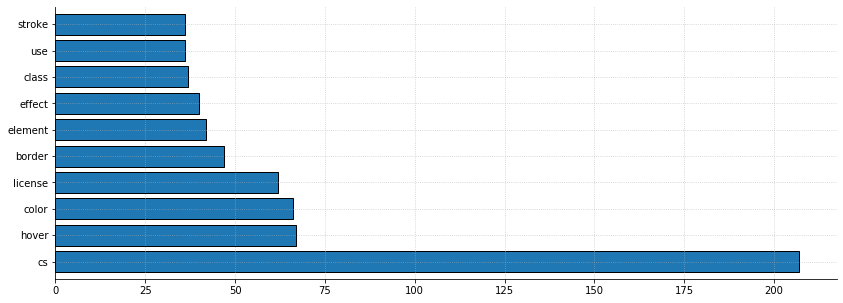

In [53]:
plt.figure(figsize=(14,5))
css_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

In [54]:
ruby = df[df.language == 'Ruby'].sort_values(by='readme_length', ascending=True)
css.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
61,CSS,960 Grid System\n===============\n\nCreated by...,grid system created nathan s...,grid system creat nathan smith see the offici ...,grid system created nathan smith see the offic...,grid system created nathan smith see official ...,1349
71,CSS,# Basscss\n\nLow-level CSS toolkit – the origi...,basscss low level css toolkit the original ...,basscss low level css toolkit the origin funct...,basscss low level cs toolkit the original func...,low level cs toolkit original functional cs fu...,1882
70,CSS,# [Photon](http://photonkit.com/)\n\n[![Build ...,photon http photonkit com build statu...,photon http photonkit com build statu http img...,photon http photonkit com build status http im...,photonkit build status img shield travis maste...,1941
64,CSS,\n# [Flat UI Free](https://designmodo.github.i...,flat free https designmodo github flat ...,flat free http designmodo github flat flat bea...,flat free http designmodo github flat flat bea...,flat free flat flat beautiful theme getbootstr...,2201
62,CSS,"# normalize.css\n\n<a href=""https://github.com...",normalize css href https github com neco...,normal css href http github com necola normal ...,normalize cs href http github com necolas norm...,normalize cs href normalize cs img src normali...,2226


In [55]:
ruby_words = pd.Series(" ".join(ruby.cleaned).split()).value_counts()
ruby_words.head(15)

sc                155
opencollective    128
svg               124
file               90
org                69
sponsor            68
img                65
backer             65
sonic              65
website            64
src                62
target             61
avatar             60
href               60
blank              60
dtype: int64

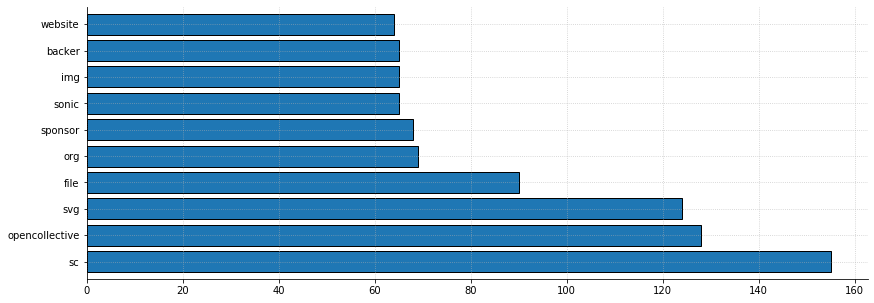

In [56]:
plt.figure(figsize=(14,5))
ruby_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

In [57]:
go = df[df.language == 'Go'].sort_values(by='readme_length', ascending=True)
css.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
61,CSS,960 Grid System\n===============\n\nCreated by...,grid system created nathan s...,grid system creat nathan smith see the offici ...,grid system created nathan smith see the offic...,grid system created nathan smith see official ...,1349
71,CSS,# Basscss\n\nLow-level CSS toolkit – the origi...,basscss low level css toolkit the original ...,basscss low level css toolkit the origin funct...,basscss low level cs toolkit the original func...,low level cs toolkit original functional cs fu...,1882
70,CSS,# [Photon](http://photonkit.com/)\n\n[![Build ...,photon http photonkit com build statu...,photon http photonkit com build statu http img...,photon http photonkit com build status http im...,photonkit build status img shield travis maste...,1941
64,CSS,\n# [Flat UI Free](https://designmodo.github.i...,flat free https designmodo github flat ...,flat free http designmodo github flat flat bea...,flat free http designmodo github flat flat bea...,flat free flat flat beautiful theme getbootstr...,2201
62,CSS,"# normalize.css\n\n<a href=""https://github.com...",normalize css href https github com neco...,normal css href http github com necola normal ...,normalize cs href http github com necolas norm...,normalize cs href normalize cs img src normali...,2226


In [58]:
go_words = pd.Series(" ".join(go.cleaned).split()).value_counts()
go_words.head(15)

org          105
page          45
facing        43
build         43
client        27
docker        23
golint        22
project       22
cloud         21
master        19
godoc         18
run           18
doc           17
file          16
container     16
dtype: int64

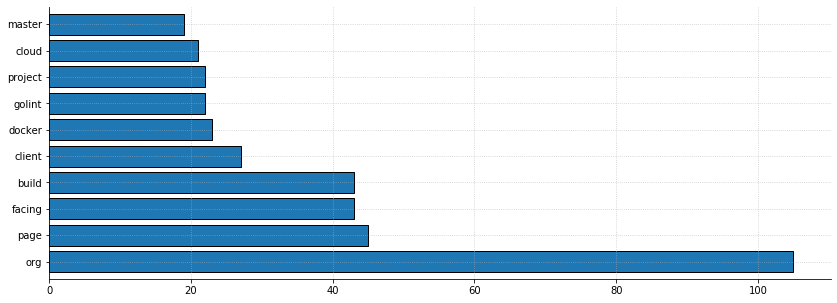

In [59]:
plt.figure(figsize=(14,5))
go_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

**Takeaway:** The top 5 languages vary in the max number of one word used. With the stopwords removed, we can see that the languages have a general range of numbers of the same word lengths.

### Analysis

We scraped a random collection of Github repository README's in order to gather a diverse selection of programming languages. We found from this process that the most prominent language from our scraping was JavaScrit, followed by Python and then Ruby. 

### Model

We want to look into the languages with only one appearance and remove those in order to stratify and run our models.

In [60]:
df.language.value_counts()[df.language.value_counts() == 1]

CoffeeScript    1
Haskell         1
Clojure         1
C#              1
Kotlin          1
Rust            1
Name: language, dtype: int64

In [61]:
list(df.language.value_counts()[df.language.value_counts() == 1].index)

['CoffeeScript', 'Haskell', 'Clojure', 'C#', 'Kotlin', 'Rust']

In [62]:
df[df.language == 'Kotlin']
df = df.drop(20)
df[df.language == 'C#']
df = df.drop(21)
df[df.language == 'CoffeeScript']
df = df.drop(28)
df[df.language == 'Clojure']
df = df.drop(85)
df[df.language == 'Haskell']
df = df.drop(41)
df[df.language == 'Rust']
df = df.drop(3)

In [63]:
df = df.reset_index()

In [64]:
df.language.value_counts()

JavaScript          25
Python              20
CSS                  9
Ruby                 9
Go                   7
Java                 5
HTML                 5
TypeScript           4
C++                  4
C                    2
Jupyter Notebook     2
PHP                  2
Name: language, dtype: int64

#### *Logistic Regression*

In [65]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=321)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [66]:
lm = LogisticRegression(random_state=123).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [67]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')

Accuracy: 36.84%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Jupyter Notebook  PHP  \
predicted                                                                    
CSS         0    0    7   0     0     0           0                 0    0   
JavaScript  2    3    0   5     4     4          20                 2    2   
Python      0    0    0   0     0     0           0                 0    0   
Ruby        0    0    0   0     0     0           0                 0    0   

actual      Python  Ruby  TypeScript  
predicted                             
CSS              0     0           0  
JavaScript       0     4           3  
Python          16     0           0  
Ruby             0     3           0  
---


In [68]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---') 
print(classification_report(test.actual, test.predicted))

Accuracy: 36.84%
---
Confusion Matrix
actual      C++  CSS  Go  HTML  Java  JavaScript  Python  Ruby  TypeScript
predicted                                                                 
JavaScript    1    2   2     1     1           5       2     2           1
Python        0    0   0     0     0           0       2     0           0
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         1
         CSS       0.00      0.00      0.00         2
          Go       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         1
        Java       0.00      0.00      0.00         1
  JavaScript       0.29      1.00      0.45         5
      Python       1.00      0.50      0.67         4
        Ruby       0.00      0.00      0.00         2
  TypeScript       0.00      0.00      0.00         1

    accuracy                           0.37        19
   macro avg       0.14      0.17      0.12        19
weighted

#### *Decision Tree*

In [69]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [70]:
print(clf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [71]:
y_pred = clf.predict(X_train)
y_pred

array(['JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'CSS', 'JavaScript', 'Python', 'Ruby',
       'JavaScript', 'JavaScript', 'JavaScript', 'CSS', 'Ruby',
       'JavaScript', 'JavaScript', 'JavaScript', 'CSS', 'Ruby',
       'JavaScript', 'Ruby', 'HTML', 'JavaScript', 'CSS', 'Python',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Ruby', 'CSS', 'Ruby', 'Ruby', 'JavaScript',
       'Python', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'Ruby', 'Ruby', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'Python',
       'Ruby', 'Ruby', 'Python', 'Ruby', 'Ruby', 'JavaScript', 'Python',
       'Python', 'Python', 'JavaScript', 'C', 'JavaScript', 'JavaScript',
       'Ruby', 'JavaScript', 'JavaScript', 'CSS', 'Ruby'], dtype=object)

In [72]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.03846154, 0.11538462, 0.        , 0.07692308, 0.        ,
        0.15384615, 0.23076923, 0.07692308, 0.03846154, 0.15384615,
        0.07692308, 0.03846154],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.03846154, 0.11538462, 0.        , 0.07692308, 0.        ,
        0.15384615, 0.23076923, 0.07692308, 0.03846154, 0.15384615,
        0.07692308, 0.03846154],
       [0.03846154, 0.11538462, 0.        , 0.07692308, 0.        ,
        0.15384615, 0.23076923, 0.07692308, 0.03846154, 0.15384615,
        0.07692308, 0.03846154],
       [0.03846154, 0.11538462, 0.        , 0.07692308, 0.        ,
        0.15384615, 0.23076923, 0.07692308, 0.03846154, 0.15384615,
        0.07692308, 0.03846154],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ,

In [73]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.59


In [74]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.42


In [75]:
confusion_matrix(y_train, y_pred)

array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0, 12,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  5,  0],
       [ 0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0]])

#### *Random Forest*

In [76]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)

In [77]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [78]:
print(rf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [79]:
y_pred = rf.predict(X_train)
y_pred

array(['Python', 'JavaScript', 'Python', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'Python', 'JavaScript', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'Python',
       'Python', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'Python', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'Python',
       'Python', 'JavaScript', 'JavaScript', 'Python

In [80]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[0.02961445, 0.04711335, 0.07117455, 0.0586714 , 0.04628462,
        0.0717228 , 0.23742692, 0.04449717, 0.02307704, 0.24193897,
        0.08880376, 0.03967497],
       [0.02791037, 0.04934119, 0.0874802 , 0.07199697, 0.05246114,
        0.06416254, 0.28038289, 0.03194808, 0.03268954, 0.19905532,
        0.07255167, 0.0300201 ],
       [0.03164484, 0.04459232, 0.06243152, 0.06813001, 0.04987225,
        0.08740687, 0.23774778, 0.04544159, 0.02673344, 0.24076571,
        0.07194447, 0.0332892 ],
       [0.02672726, 0.0386096 , 0.0768745 , 0.06248464, 0.05005512,
        0.04621651, 0.22625638, 0.02639158, 0.02534969, 0.28163246,
        0.09721876, 0.04218351],
       [0.02565042, 0.07322913, 0.09244047, 0.06513647, 0.05473276,
        0.05023932, 0.23879459, 0.0273622 , 0.02168433, 0.21358454,
        0.09827783, 0.03886795],
       [0.02552481, 0.04340315, 0.09230235, 0.06551681, 0.05765111,
        0.0401062 , 0.31626131, 0.02466503, 0.01589081, 0.19337981,
        0.090312  ,

In [81]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.43


In [82]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.37


In [83]:
print(confusion_matrix(y_train, y_pred))

[[ 0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0  2  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0 12  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]]


In [84]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.34      1.00      0.51        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       0.71      0.75      0.73        16
            Ruby       0.00      0.00      0.00         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.43        75
       macro avg       0.09      0.15      0.10        75
    weighted avg       0.24      0.43      0.29        75



#### *K-Nearest Neighbors*

In [85]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [86]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [87]:
y_pred = knn.predict(X_train)
y_pred

array(['JavaScript', 'JavaScript', 'Java', 'Python', 'C++', 'JavaScript',
       'CSS', 'JavaScript', 'Python', 'CSS', 'C++', 'JavaScript',
       'JavaScript', 'JavaScript', 'Go', 'C++', 'Go', 'JavaScript', 'CSS',
       'Ruby', 'Python', 'JavaScript', 'JavaScript', 'JavaScript', 'CSS',
       'Python', 'C++', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'CSS', 'CSS', 'CSS', 'Ruby', 'Go',
       'Python', 'CSS', 'C', 'JavaScript', 'JavaScript', 'Ruby', 'Python',
       'JavaScript', 'Ruby', 'JavaScript', 'JavaScript', 'Python',
       'Python', 'JavaScript', 'JavaScript', 'JavaScript', 'Python',
       'C++', 'JavaScript', 'Python', 'Go', 'Go', 'Python', 'JavaScript',
       'Ruby', 'JavaScript', 'Java', 'Python', 'Python', 'JavaScript',
       'C', 'Go', 'JavaScript', 'CSS', 'JavaScript', 'JavaScript', 'CSS',
       'CSS'], dtype=object)

In [88]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba

array([[0. , 0.2, 0. , 0. , 0.2, 0. , 0.4, 0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0.2, 0. , 0. , 0. , 0.6, 0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0.2, 0. , 0. , 0.4, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.2, 0. , 0.2, 0. , 0. , 0.4, 0.2, 0. ],
       [0. , 0.2, 0. , 0.2, 0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0.2],
       [0. , 0. , 0.8, 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0.8, 0. , 0. ],
       [0. , 0. , 0.6, 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0.2],
       [0. , 0.2, 0. , 0.2, 0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0. ],
       [0. , 0. , 0.2, 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0.2, 0. ],
       [0. , 0. , 0.2, 0.2, 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0. , 0.4, 0. , 0. , 0.2, 0. , 0.2],
       [0. , 0. , 0. , 0.6, 0. , 0

In [89]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.67


In [90]:
print(confusion_matrix(y_train, y_pred))

[[ 1  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  2  0  0  0  1  0]
 [ 0  0  0  0  0  1  3  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  3  0  0 12  0  0]
 [ 0  0  1  1  0  0  1  0  0  1  3  0]
 [ 1  0  1  0  0  0  1  0  0  0  0  0]]


In [91]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       0.50      0.50      0.50         2
             C++       0.60      1.00      0.75         3
             CSS       0.64      1.00      0.78         7
              Go       0.67      0.80      0.73         5
            HTML       0.00      0.00      0.00         4
            Java       0.50      0.25      0.33         4
      JavaScript       0.61      0.95      0.75        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       0.92      0.75      0.83        16
            Ruby       0.60      0.43      0.50         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.67        75
       macro avg       0.42      0.47      0.43        75
    weighted avg       0.58      0.67      0.60        75



In [92]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.63


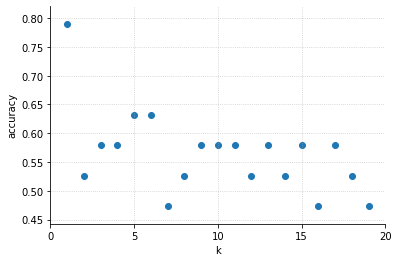

In [93]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

In [94]:
rng = np.random.RandomState(1)
X = X_train
y = y_train

clf = BernoulliNB()
clf.fit(X, y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [95]:
print(clf.predict(X))

['Python' 'JavaScript' 'JavaScript' 'Python' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'Python' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'Python'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'Python'
 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'Python' 'JavaScript'
 'JavaScript' 'Python' 'JavaScript' 'JavaScript' 'Python' 'JavaScript'
 'JavaScript' 'JavaScript' 'JavaScript' 'Python' 'JavaScript' 'JavaScript'
 'C' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript' 'JavaScript'
 'JavaScript' 'JavaScript']


In [96]:
y_pred = clf.predict(X)
y_pred

array(['Python', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaSc

In [97]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.00000000e+000, 0.00000000e+000, 1.09724802e-249,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.22540143e-037, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 4.51174575e-270, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 3.84796041e-263,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        2.40950789e-054, 5.07230390e-298, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.76303579e-178,
        4.51809031e-246, 0.00000000e+000, 8.95176668e-230,
        9.99999983e-001, 0.00000000e+000, 0.00000000e+000,
        1.71675012e-008, 5.57954529e-199, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.33176942e-251,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        5.28391459e-011, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 2.59059094e-265, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 3.31723622

In [98]:
print('Accuracy of Naive Bayes classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Naive Bayes classifier on training set: 0.40


In [99]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       1.00      0.50      0.67         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.31      1.00      0.47        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       1.00      0.56      0.72        16
            Ruby       0.00      0.00      0.00         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.40        75
       macro avg       0.19      0.17      0.15        75
    weighted avg       0.32      0.40      0.30        75



#### *Support Vector Machine (SVM)

In [100]:
X = X_train
y = y_train

clf = SVC(gamma='auto', kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [101]:
clf.predict(X)

array(['Python', 'JavaScript', 'Java', 'Python', 'C++', 'JavaScript',
       'CSS', 'JavaScript', 'Python', 'TypeScript', 'PHP', 'JavaScript',
       'JavaScript', 'TypeScript', 'Go', 'C++', 'Ruby', 'JavaScript',
       'CSS', 'Ruby', 'Python', 'JavaScript', 'HTML', 'Java', 'CSS',
       'Python', 'Go', 'Python', 'JavaScript', 'Java', 'JavaScript',
       'JavaScript', 'CSS', 'CSS', 'Ruby', 'Ruby', 'Go', 'Python',
       'JavaScript', 'TypeScript', 'Jupyter Notebook', 'JavaScript',
       'HTML', 'Ruby', 'JavaScript', 'C', 'JavaScript', 'JavaScript',
       'Python', 'Python', 'JavaScript', 'Python', 'JavaScript', 'Python',
       'C++', 'JavaScript', 'Python', 'Go', 'Go', 'Python', 'HTML',
       'Ruby', 'JavaScript', 'Python', 'Python', 'Python', 'JavaScript',
       'C', 'Jupyter Notebook', 'JavaScript', 'CSS', 'JavaScript',
       'JavaScript', 'CSS', 'HTML'], dtype=object)

In [102]:
print('Accuracy of Stochastic SVM on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Stochastic SVM on training set: 0.96


In [103]:
print('Accuracy of Stochastic SVM on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Stochastic SVM on test set: 0.42


#### *Stochastic Gradient Descent* 

In [104]:
X = X_train
y = y_train
# clf = linear_model.SGDClassifier(max_iter=, tol=1e-3)
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
clf.predict(X)

array(['Python', 'JavaScript', 'Java', 'Python', 'C++', 'JavaScript',
       'CSS', 'JavaScript', 'Python', 'TypeScript', 'PHP', 'JavaScript',
       'JavaScript', 'TypeScript', 'Go', 'C++', 'Ruby', 'JavaScript',
       'CSS', 'Ruby', 'Python', 'PHP', 'HTML', 'Java', 'CSS', 'Python',
       'Go', 'Python', 'JavaScript', 'Java', 'JavaScript', 'JavaScript',
       'CSS', 'CSS', 'Ruby', 'Ruby', 'Go', 'Python', 'JavaScript',
       'TypeScript', 'Jupyter Notebook', 'JavaScript', 'HTML', 'Ruby',
       'JavaScript', 'C', 'JavaScript', 'Java', 'Python', 'Python',
       'JavaScript', 'Python', 'JavaScript', 'Python', 'C++',
       'JavaScript', 'Python', 'Go', 'Go', 'Python', 'HTML', 'Ruby',
       'JavaScript', 'Python', 'Python', 'Python', 'JavaScript', 'C',
       'Jupyter Notebook', 'JavaScript', 'CSS', 'JavaScript', 'Ruby',
       'CSS', 'HTML'], dtype='<U16')

In [106]:
print('Accuracy of Stochastic Gradient Decent Classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Stochastic Gradient Decent Classifier on training set: 1.00


In [107]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       1.00      0.50      0.67         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.31      1.00      0.47        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       1.00      0.56      0.72        16
            Ruby       0.00      0.00      0.00         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.40        75
       macro avg       0.19      0.17      0.15        75
    weighted avg       0.32      0.40      0.30        75



In [108]:
print('Accuracy of Stochastic Gradient Decent classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of Stochastic Gradient Decent classifier on test set: 0.47


#### *AdaBoost*

In [109]:
X = X_train
y = y_train
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [110]:
print(clf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [111]:
clf.predict(X)

array(['JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'PHP', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'PHP', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'C',
       'JavaScript', 'JavaScript', 'Python', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'Python', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'Python', 'Python', 'Python',
       'C', 'JavaScript', 'JavaScript',

In [112]:
print('Accuracy of AdaBoost classifier on training set: {:.2f}'
     .format(clf.score(X, y)))

Accuracy of AdaBoost classifier on training set: 0.47


#### *Bagging*

In [113]:
X = X_train
y = y_train

clf = BaggingClassifier(n_estimators=3, random_state=0)
clf.fit(X, y)
clf.predict(X)

array(['Python', 'JavaScript', 'Java', 'Python', 'C++', 'JavaScript',
       'CSS', 'JavaScript', 'Python', 'TypeScript', 'PHP', 'JavaScript',
       'C++', 'TypeScript', 'Go', 'C++', 'Ruby', 'JavaScript', 'CSS',
       'Ruby', 'Python', 'PHP', 'HTML', 'Java', 'JavaScript', 'Python',
       'C++', 'Python', 'JavaScript', 'Go', 'JavaScript', 'JavaScript',
       'CSS', 'CSS', 'Ruby', 'Jupyter Notebook', 'Go', 'Python',
       'JavaScript', 'TypeScript', 'Go', 'JavaScript', 'Python', 'Ruby',
       'Go', 'C', 'JavaScript', 'Java', 'Python', 'Python', 'JavaScript',
       'Go', 'CSS', 'Python', 'C++', 'JavaScript', 'Python', 'C++', 'Go',
       'Python', 'HTML', 'Ruby', 'Python', 'Python', 'Python', 'Python',
       'JavaScript', 'C', 'Jupyter Notebook', 'JavaScript', 'CSS',
       'JavaScript', 'Ruby', 'CSS', 'HTML'], dtype=object)

In [114]:
print('Accuracy of Bagging classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Bagging classifier on training set: 0.84


In [118]:
print('Accuracy of Bagging classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Bagging classifier on test set: 0.32


### Takeaways:

K-Nearest Neighbors worked the best out of all the models with a train accuracy of 67% and a test accuracy 63%. This was with the hyperparameter number of neighbors, equal to 5 (n_neighbors = 5).

The model can be improved by adding more repositories in order to get a more representative sample of GitHub repos.  Scaling the list of repos should lead to logarithmic improvements in the model, meaning it should get ever diminishing returns until it peaks at a certain value and never passing it.